In [1]:
from pisces.experiments import evaluate_mo_on_data_set, MOResUNetPretrained
from pisces.experiments import DataSetObject
from pisces.utils import add_rocs, plot_scores_PDF


sets = DataSetObject.find_data_sets("../data_sets")
hfd = sets['henry_ford_disordered']

In [2]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

loo = LeaveOneOutSplitter()
walch = sets['walch_et_al']

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, walch, SGDLogisticRegression)

ID 7749105 not found in walch_et_al


31it [00:02, 10.78it/s]


In [ ]:


from typing import Dict, List

from pisces.experiments import split_analysis
log_reg_aucs_hf = []
log_reg_fprs_hf = []
log_reg_tprs_hf = []



DATA_SET = hfd

log_reg_preprocessed_data_hf = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[0].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hf: List[Dict[str, dict]] = []
for i in range(len(split_models)):
    split_evals = {}
    for (X, y), id in log_reg_preprocessed_data_hf:
        y_hat_proba = split_models[i].predict_probabilities(X)
        y_hat_sleep_proba = y_hat_proba[:, 1].reshape(-1,)
        y_prepped, _ = SGDLogisticRegression()._prepare_labels(y)
        try:
            analysis = split_analysis(y_prepped, y_hat_sleep_proba, balancing=False)
        except ValueError as e:
            print(f"Error processing {id}: {e}")
            continue
        # analysis = split_analysis(y, y_hat_proba)
        split_evals[id] = analysis
        print(f"Processed {i+1} of {len(log_reg_preprocessed_data_hf)} ({id})... AUROC: {analysis['auc']}")
    log_reg_evaluations_hf.append(split_evals)
    log_reg_aucs_hf.append([e["auc"] for e in split_evals.values()])
    log_reg_fprs_hf.append([e["roc_curve"]["fprs"] for e in split_evals.values()])
    log_reg_tprs_hf.append([e["roc_curve"]["tprs"] for e in split_evals.values()])


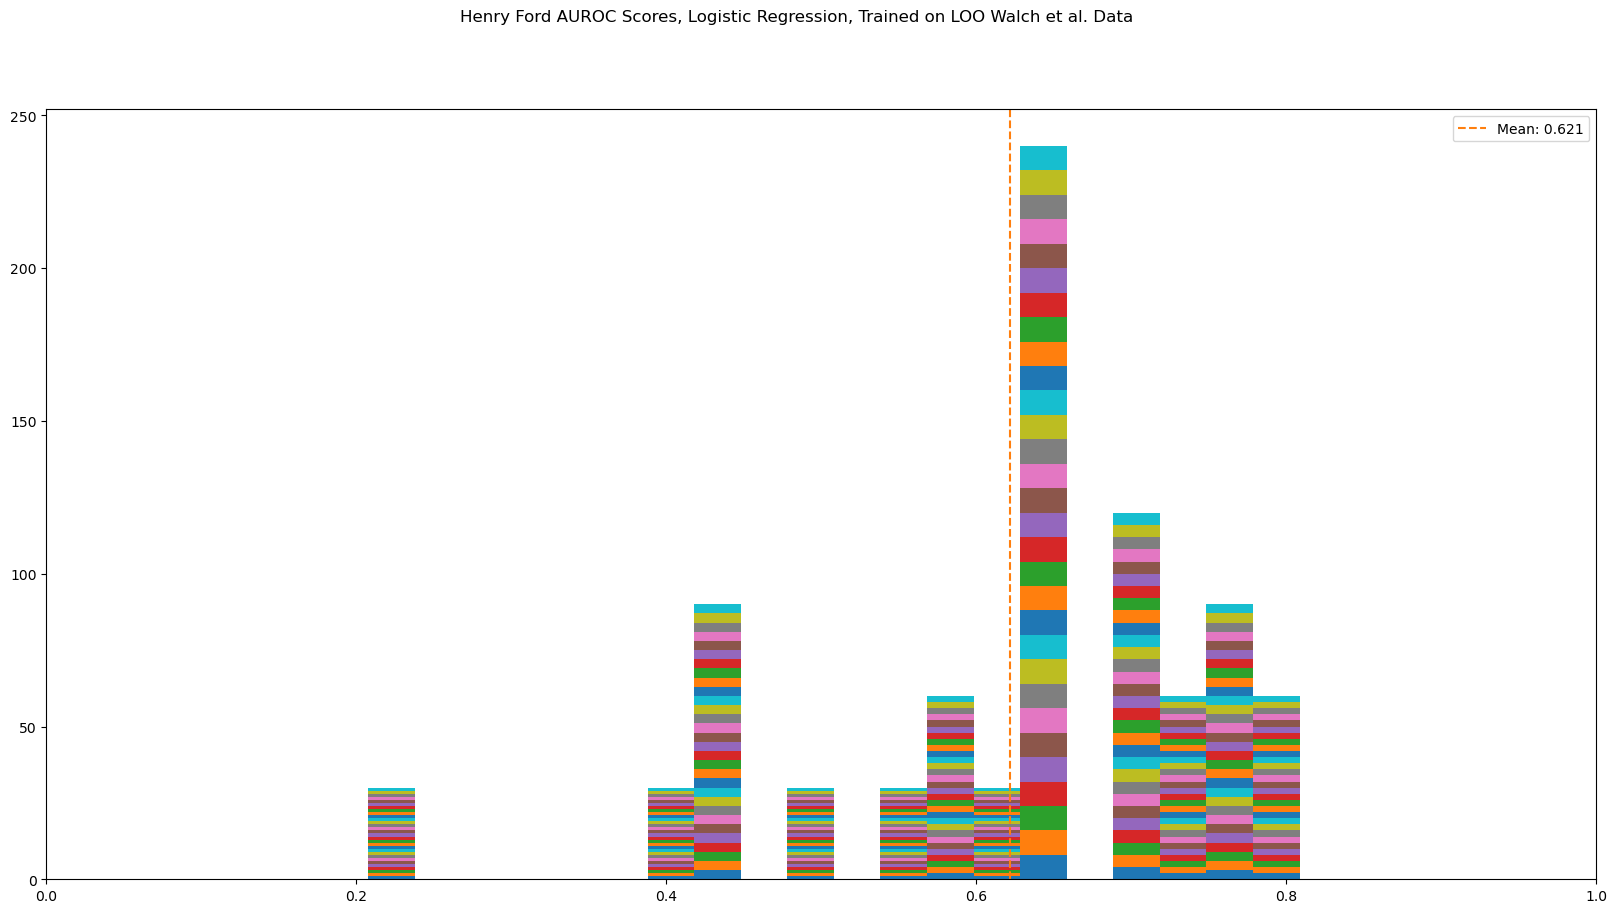

In [6]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Henry Ford AUROC Scores, Logistic Regression, Trained on LOO Walch et al. Data")
plot_scores_PDF(log_reg_aucs_hf, ax=ax)
ax.legend()
# for i in range(len(log_reg_aucs_hf)):
#     plot_scores_PDF(log_reg_aucs_hf[i], ax=ax, hist_alpha=0.1)

# Mads Olsen ResUNet inference

This can probably be improved by fine-tuning on Walch et al.

In [ ]:
mo = MOResUNetPretrained(sampling_hz=32)

results = evaluate_mo_on_data_set(mo, hfd)

In [ ]:
evaluations_hf, mo_preprocessed_data_hf = results
mo_aucs_hf = [e["auc"] for e in evaluations_hf.values()]
mo_fprs_hf = [e["roc_curve"]["fprs"] for e in evaluations_hf.values()]
mo_tprs_hf = [e["roc_curve"]["tprs"] for e in evaluations_hf.values()]

In [ ]:



plot_scores_CDF(mo_aucs_hf)

In [ ]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones


plot_scores_PDF(mo_aucs_hf)

add_rocs(mo_fprs_hf, mo_tprs_hf, roc_group_name="MO")